# Import, filter data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
# Import dataset
raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
raw_data_df.shape

(7214, 53)

In [3]:
raw_data_df[:5]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
# Filter out the dataset similarly to the way ProPublica did
# see: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
filter_data_df = raw_data_df
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
filter_data_df.shape

(6172, 53)

## Split data into "training", "test"

In [5]:
split_ratio = 0.8

filter_data_df_src = filter_data_df.sample(n=int(split_ratio*len(filter_data_df)))
filter_data_df_test = filter_data_df[~filter_data_df.index.isin(filter_data_df_src.index)]

print(filter_data_df_src.shape)
print(filter_data_df_test.shape)

(4937, 53)
(1235, 53)


# Define rationalization

In [6]:
# Fields accessible to use in rationalization?
# ... some of which are VERY unfair
accessible_fields = [
    # 'sex', # >:(
    # 'race', # >:(
    'age',
    'age_cat',
    'juv_fel_count',
    'decile_score',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
]
# Field we are trying to rationalize why it could be 1 vs 0
justifying_field = 'is_recid' # 'is_recid' or 'is_violent_recid'
# Field that is the actual data for what we are trying to determine
trueresult_field = 'two_year_recid'

In [7]:
from statsmodels.stats import proportion

def rationalize(target, data_df, numfields=1):
    def noIntervalOverlap(a1, a2, b1, b2):
        if a1>a2 or b1>b2:
            raise ValueError('unexpected bounds')
        if a2<b1 and a1<b1:
            return True
        if b2<a1 and b1<a1:
            return True
        return False
    breakdown = data_df[trueresult_field]
    full_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
    result_df = pd.DataFrame()
    field_groups = [[i] for i in range(len(accessible_fields))]
    for _ in range(numfields-1):
        field_groups = [[f+[i] for i in range(len(accessible_fields)) if i>f[-1]] for f in field_groups]
        field_groups = [e for l in field_groups for e in l]
    for field_ids in field_groups:
        field_names = [accessible_fields[i] for i in field_ids]
        subgroup = data_df
        for field in field_names:
            subgroup = subgroup[subgroup[field] == target[field]]
        subgroup_alt = data_df[~data_df.index.isin(subgroup.index)]
        breakdown = subgroup[trueresult_field]
        breakdown_alt = subgroup_alt[trueresult_field]
        if len(breakdown)>0:
            conf_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
            altg_interval = proportion.proportion_confint(sum(breakdown_alt), len(breakdown_alt), alpha=0.05, method='beta')
            result_df = result_df.append({
                'id': target['id'],
                'field_count': len(field_names),
                'fields': field_names,
                'sample_size': len(breakdown),
                'percent_recid': sum(breakdown) / len(breakdown),
                'percent_recid_alt': sum(breakdown_alt) / len(breakdown_alt),
                # Confidence interval: in 95% of cases, the true underlying fraction of recidivism will fall within this interval
                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                # https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportion_confint.html
                'conf_95_bot': conf_interval[0],
                'conf_95_top': conf_interval[1],
                # Statistical significance
                'significant_baseline': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], full_interval[0], full_interval[1]) else 0,
                'significant_altgroup': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], altg_interval[0], altg_interval[1]) else 0,
            }, ignore_index=True)
    return result_df

In [8]:
breakdown = filter_data_df_src[trueresult_field]
print('true recidivism (training):', sum(breakdown)/len(breakdown))
print('true recidivism (training) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta'))

print()

breakdown = filter_data_df_test[trueresult_field]
print('true recidivism (testing):', sum(breakdown)/len(breakdown))
print('true recidivism (testing) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta'))

true recidivism (training): 0.45553980149888595
true recidivism (training) range: (0.4415763481377187, 0.46955587132714205)

true recidivism (testing): 0.4534412955465587
true recidivism (testing) range: (0.42541079293463746, 0.4816939543586095)


In [ ]:
# Mini-example of selecting someone to justify both-sides of
target = filter_data_df[filter_data_df['id'] == 2680].iloc[0] # filter_data_df.sample(n=1).iloc[0]
filter_data_df[filter_data_df['id'] == target['id']]

rationalize_df = pd.DataFrame()
for numfields in [1,2,3]:
    rationalize_df = rationalize_df.append(
        rationalize(target, filter_data_df_src, numfields=numfields),
        ignore_index=True
    )

# rationalize_df.sort_values(['significant_baseline', 'percent_recid'])
rationalize_df[rationalize_df['significant_baseline'] == 1].sort_values('percent_recid')

# Visualize small sample of rationalization bounds

In [10]:
import numpy as np
import matplotlib.pyplot as plt

count_bothsides = 10
count_factors = 3

def vis(filter_data_df_src, filter_data_df_test, count_bothsides, count_factors):
    plt.rcParams['figure.figsize'] = [15, 5]
    gap_size = 10
    
    # Randomly select someone to justify negative pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 0].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n) for i in rationalize_df['field_count']],
            rationalize_df['percent_recid'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            range_lo = min(temp_df['conf_95_top'])
            range_hi = max(temp_df['conf_95_bot'])
            pos_x = (2*i)+(2*count_factors*n)+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )

    # Randomly select someone to justify positive pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 1].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size for i in rationalize_df['field_count']], 
            rationalize_df['percent_recid'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            if len(temp_df)==0:
                pass
            if len(temp_df['conf_95_top'])==0:
                print(temp_df)
                raise ValueError()
            range_lo = min(temp_df['conf_95_top'])
            if len(temp_df['conf_95_bot'])==0:
                print(temp_df)
                raise ValueError()
            range_hi = max(temp_df['conf_95_bot'])
            pos_x = (2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )
    
    # population mean line
    breakdown = filter_data_df_src[trueresult_field]
    src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
    plt.axline((1, sum(breakdown)/len(breakdown)), slope=0, alpha=0.4)
    plt.fill_between(
        [0, 4*count_factors*count_bothsides+gap_size+2], 
        [src_range[1], src_range[1]], 
        [src_range[0], src_range[0]], 
        alpha=0.2
    )
    # 50% line
    plt.axline((1, 0.5), slope=0, alpha=0.8)
    plt.show()

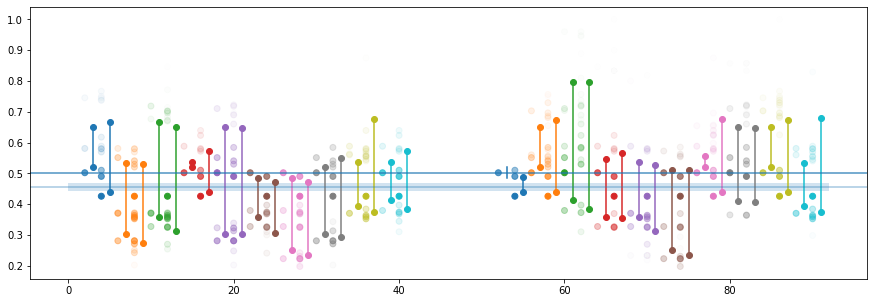

In [11]:
vis(filter_data_df_src, filter_data_df_test, 10, 2)

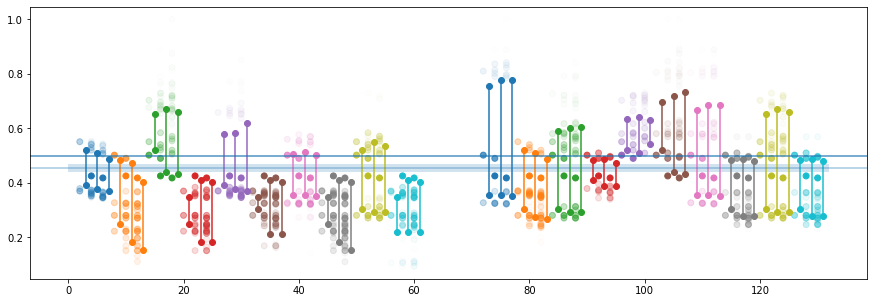

In [12]:
vis(filter_data_df_src, filter_data_df_test, 10, 3)

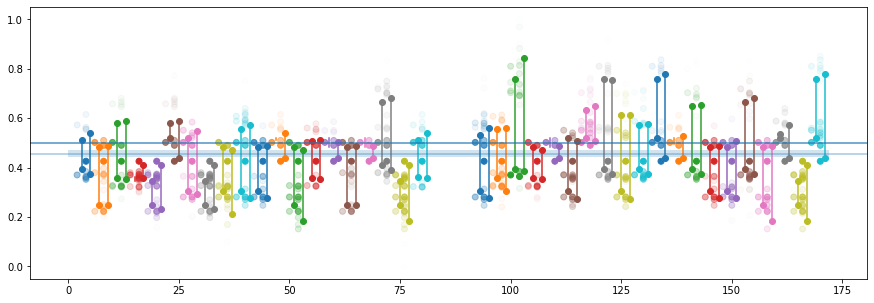

In [13]:
vis(filter_data_df_src, filter_data_df_test, 20, 2)

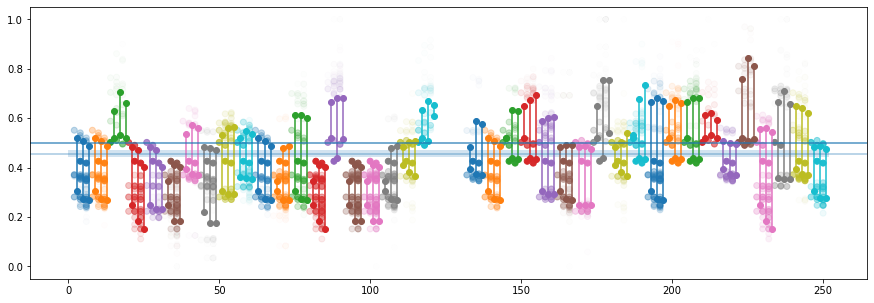

In [14]:
vis(filter_data_df_src, filter_data_df_test, 20, 3)

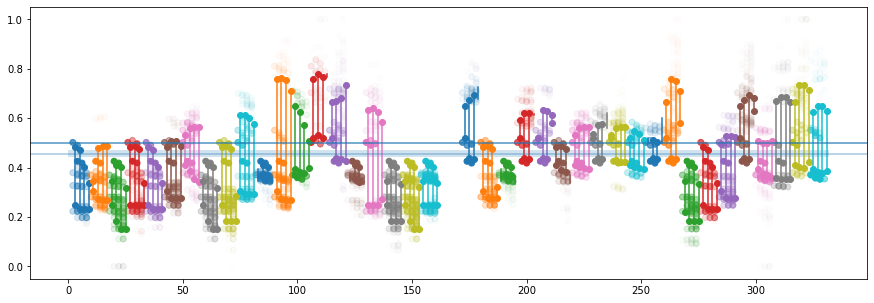

In [15]:
vis(filter_data_df_src, filter_data_df_test, 20, 4)

# Calculate rationalization for ALL test set samples

In [16]:
# Calculate rationalization for all test set samples

count_factors = 2

test_rationalizations = pd.DataFrame()
for _, case in filter_data_df_test.iterrows():
    for numfields in range(1, count_factors+1):
        test_rationalizations = pd.concat(
            [
                test_rationalizations,
                rationalize(case, filter_data_df_src, numfields=numfields),
            ],
            ignore_index=True,
        )

# Add column representing the 'side' that each rationalization is in favor of
breakdown = filter_data_df_src[trueresult_field]
justifying_ref_avg = sum(breakdown)/len(breakdown)
test_rationalizations['is_recid_rat_side'] = test_rationalizations.apply(lambda r: 1 if r['percent_recid']>justifying_ref_avg else 0, axis=1)

test_rationalizations[:20]

,id,field_count,fields,sample_size,percent_recid,percent_recid_alt,conf_95_bot,conf_95_top,significant_baseline,significant_altgroup
0,1.0,1.0,[age],13.0,0.307692,0.455930,0.090920,0.614262,0.0,0.0
1,1.0,1.0,[age_cat],1020.0,0.327451,0.488895,0.298694,0.357207,1.0,1.0
2,1.0,1.0,[juv_fel_count],4764.0,0.445004,0.745665,0.430825,0.459251,0.0,1.0
3,1.0,1.0,[decile_score],1022.0,0.223092,0.516220,0.197906,0.249884,1.0,1.0
4,1.0,1.0,[juv_misd_count],4663.0,0.439631,0.726277,0.425319,0.454019,0.0,1.0
5,1.0,1.0,[juv_other_count],4570.0,0.435667,0.702997,0.421227,0.450190,0.0,1.0
6,1.0,1.0,[priors_count],1665.0,0.281081,0.544315,0.259590,0.303347,1.0,1.0
7,1.0,1.0,[c_charge_degree],3195.0,0.502034,0.370264,0.484546,0.519520,1.0,1.0
8,1.0,1.0,[c_charge_desc],19.0,0.263158,0.456283,0.091466,0.512029,0.0,0.0
9,1.0,2.0,"[age, age_cat]",13.0,0.307692,0.455930,0.090920,0.614262,0.0,0.0


In [17]:
# Calculate confidence interval of entire training dataset
breakdown = filter_data_df_src[trueresult_field]
src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=0.05, method='beta')
src_range

(0.4415763481377187, 0.46955587132714205)

# Visualize all test-set results?

## Show distribution of confidence interval gaps

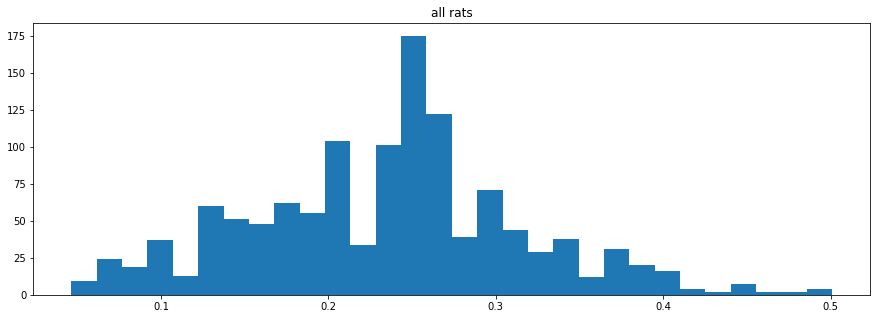

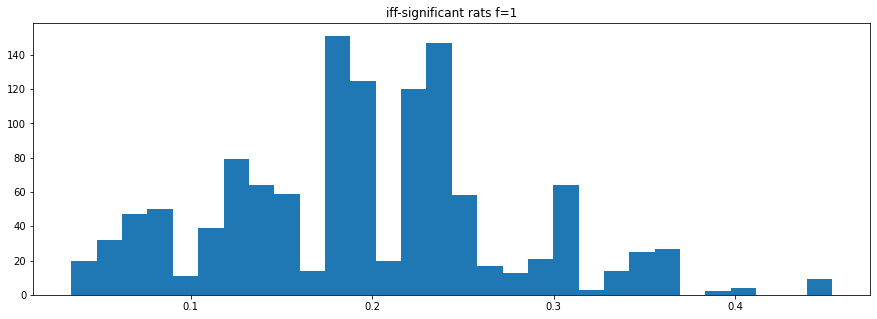

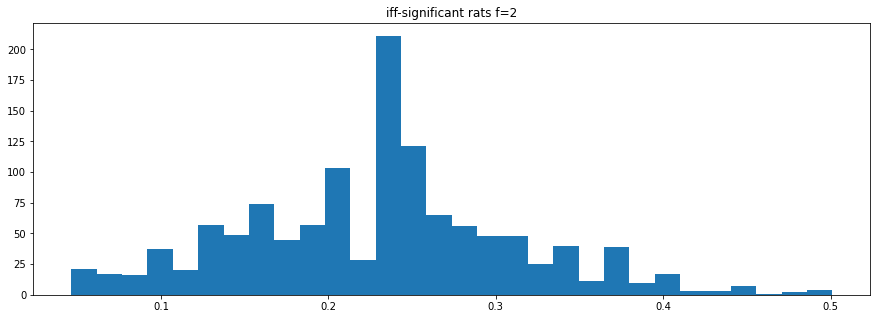

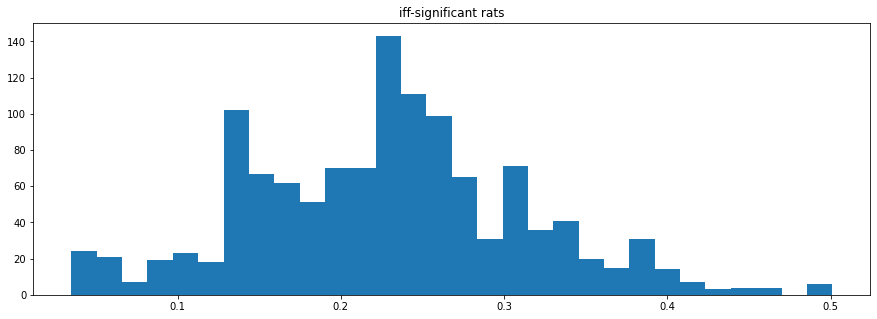

In [18]:
import matplotlib.pyplot as plt
import numpy as np

num_bins = 30

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0"
temp_gaps = []
for x_id, x_rat in test_rationalizations.groupby(['id']):
    range_lo = min(x_rat['conf_95_top'])
    range_hi = max(x_rat['conf_95_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('all rats')
plt.show()

# CI gaps ... for size-1 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations[test_rationalizations['field_count'] == 1].groupby(['id']):
    range_lo = min(x_rat['conf_95_top'])
    range_hi = max(x_rat['conf_95_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('iff-significant rats f=1')
plt.show()

# CI gaps ... for size-2 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations[test_rationalizations['field_count'] == 2].groupby(['id']):
    range_lo = min(x_rat['conf_95_top'])
    range_hi = max(x_rat['conf_95_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('iff-significant rats f=2')
plt.show()

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0" for ONLY the significant sets (???)
test_signif_rat = test_rationalizations[test_rationalizations['significant_baseline'] == 1]
temp_gaps = []
for x_id, x_rat in test_signif_rat.groupby(['id']):
    range_lo = min(x_rat['conf_95_top'])
    range_hi = max(x_rat['conf_95_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('iff-significant rats (???)')
plt.show() 

## Show single-rat and double-rat cases

In [55]:
tags = {'id':[], 'ratted_single':[], 'ratted_double':[]}
for x_id, x_rat in test_rationalizations[test_rationalizations['significant_baseline'] == 1].groupby(['id']):
    tags['id'].append(x_id)
    x_goal = filter_data_df_test[filter_data_df_test['id']==x_id].iloc[0][justifying_field]
    # figure out if goal has been achieved to prediction case-by-case
    tags['ratted_single'].append(any(x_rat['is_recid_rat_side']==x_goal))
    # figure out if goal could be achievable either way case-by-case
    rat_total = sum(x_rat['is_recid_rat_side'])
    tags['ratted_double'].append(rat_total<len(x_rat['is_recid_rat_side']) and rat_total>0)
test_ratsides = pd.DataFrame(tags)
test_ratsides[-10:]

,id,ratted_single,ratted_double
1225,10930.0,True,False
1226,10936.0,True,True
1227,10941.0,False,False
1228,10963.0,True,True
1229,10969.0,True,True
1230,10979.0,True,False
1231,10996.0,True,True
1232,10997.0,True,True
1233,11000.0,True,True
1234,11001.0,True,True


In [58]:
print('successful rat single', sum(test_ratsides['ratted_single'])/len(test_ratsides))
print('successful rat double', sum(test_ratsides['ratted_double'])/len(test_ratsides))

successful rat single 0.962753036437247
successful rat double 0.7846153846153846


# Do group multi-element rationalizing

In [60]:
test_rationalizations[:5]

temp_singlemerge = test_rationalizations.merge(filter_data_df_test[['id', justifying_field]], left_on='id', right_on='id')
temp_singlemerge[:5]

,id,field_count,fields,sample_size,percent_recid,percent_recid_alt,conf_95_bot,conf_95_top,significant_baseline,significant_altgroup,is_recid_rat_side
0,1.0,1.0,[age],13.0,0.307692,0.455930,0.090920,0.614262,0.0,0.0,0
1,1.0,1.0,[age_cat],1020.0,0.327451,0.488895,0.298694,0.357207,1.0,1.0,0
2,1.0,1.0,[juv_fel_count],4764.0,0.445004,0.745665,0.430825,0.459251,0.0,1.0,0
3,1.0,1.0,[decile_score],1022.0,0.223092,0.516220,0.197906,0.249884,1.0,1.0,0
4,1.0,1.0,[juv_misd_count],4663.0,0.439631,0.726277,0.425319,0.454019,0.0,1.0,0


,id,field_count,fields,sample_size,percent_recid,percent_recid_alt,conf_95_bot,conf_95_top,significant_baseline,significant_altgroup,is_recid_rat_side,is_recid
0,1.0,1.0,[age],13.0,0.307692,0.455930,0.090920,0.614262,0.0,0.0,0,0
1,1.0,1.0,[age_cat],1020.0,0.327451,0.488895,0.298694,0.357207,1.0,1.0,0,0
2,1.0,1.0,[juv_fel_count],4764.0,0.445004,0.745665,0.430825,0.459251,0.0,1.0,0,0
3,1.0,1.0,[decile_score],1022.0,0.223092,0.516220,0.197906,0.249884,1.0,1.0,0,0
4,1.0,1.0,[juv_misd_count],4663.0,0.439631,0.726277,0.425319,0.454019,0.0,1.0,0,0
